In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import img_as_float
from skimage.transform import hough_line, hough_circle, hough_circle_peaks
from skimage.feature import canny

## 1. The Hough Transform

### Problem 1.1

In [2]:
def Hough_transform(image):

    # create coordinates in parameter space
    theta_values = np.linspace(-np.pi/2, np.pi/2, image.shape[1])
    diameter = np.sqrt(image.shape[0]**2+image.shape[1]**2)
    rho_values = np.linspace(-diameter, diameter, image.shape[0])

    accumulator = np.zeros((image.shape[0], image.shape[1]))  # initialize accumulator

    # create coordinate grid in image space
    x = np.arange(image.shape[1])
    y = np.arange(image.shape[0])
    X, Y = np.meshgrid(x, y)
    
    for i in range(image.shape[0]):  # loop over all pixels in input
        for j in range(image.shape[1]):
            if image[i, j] == 0:  # check if pixel is an edge point
                continue
            elif image[i, j] == 1:
                # increment accumulator along curve corresponding to the edge point
                for k, theta in enumerate(theta_values):
                    rho = X[i, j] * np.cos(theta) + Y[i, j] * np.sin(theta)
                    l = np.abs(rho_values - rho).argmin()
                    accumulator[l, k] += 1
    
    return accumulator, theta_values, rho_values

### Problem 1.2

In [3]:
A = img_as_float(imread("cross.png"))

A_accumulator, theta_axis, rho_axis = Hough_transform(A)

max_value = np.max(A_accumulator)
rho_max_index, theta_max_index = np.where(A_accumulator==max_value)
print(f"Found maxima at: rho={rho_max_index}, theta={theta_max_index}")

Found maxima at: rho=[49 50 74 74 74], theta=[24 25 73 74 75]


In [4]:
def line(theta, rho, x):
    return (rho - x*np.cos(theta)) / np.sin(theta)

x_array = np.linspace(0, A.shape[1], 1000)
y_array1 = line(theta_axis[theta_max_index[0]], rho_axis[rho_max_index[0]], x_array)
y_array2 = line(theta_axis[theta_max_index[3]], rho_axis[rho_max_index[3]], x_array)

In [5]:
A_accumulator_skimage, theta_axis_skimage, rho_axis_skimage = hough_line(A)

(285, 180)

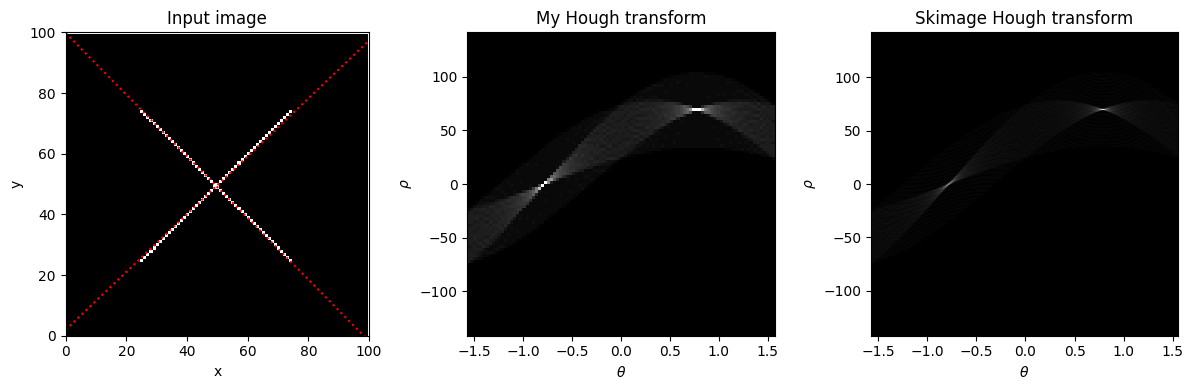

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(A, cmap="gray")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input image")
plt.plot(x_array, y_array1, "r:")
plt.plot(x_array, y_array2, "r:")
plt.ylim((0, A.shape[0]))
plt.xlim((0, A.shape[1]))

plt.subplot(1, 3, 2)
plt.imshow(A_accumulator, origin='lower', aspect="auto", extent=[theta_axis[0], theta_axis[-1], rho_axis[0], rho_axis[-1]], cmap="gray")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho$")
plt.title("My Hough transform")

plt.subplot(1, 3, 3)
plt.imshow(A_accumulator_skimage, origin='lower', aspect="auto", extent=[theta_axis_skimage[0], theta_axis_skimage[-1], rho_axis_skimage[0], rho_axis_skimage[-1]], cmap="gray")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho$")
plt.title("Skimage Hough transform")

plt.tight_layout()

A_accumulator_skimage.shape

### Problem 1.3

In [7]:
def segment_coins(image, sigma=3.0):

    image_edges = canny(image, sigma=sigma)  # find egdes of coins

    hough_radii = np.arange(10, 100)  # radii to try
    hough_res = hough_circle(image_edges, hough_radii)  # perform segmentation

    # Select the most prominent 10 circles
    _, center_x, center_y, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=2,
                                            min_ydistance=2, total_num_peaks=10)
    
    return center_x, center_y, radii, image_edges

In [8]:
B = imread("coins.png")
cx, cy, radii_coins, B_edges = segment_coins(B)

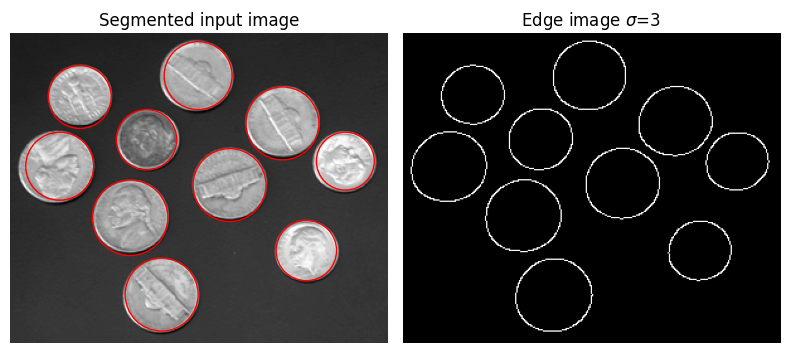

In [9]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(B, cmap="gray")
plt.axis("off")
for i in range(len(radii_coins)):
    circle = plt.Circle((cx[i], cy[i]), radii_coins[i], fill=False, color="red")
    plt.gca().add_patch(circle)
plt.title("Segmented input image")

plt.subplot(1, 2, 2)
plt.imshow(B_edges, cmap="gray")
plt.axis("off")
plt.title(r"Edge image $\sigma$=3")

plt.tight_layout()

## 2. Machine learning based segmentation

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, InputLayer
from tensorflow.keras.optimizers import Adam

## Configure the network

# batch_size to train
batch_size = 20 * 256
# number of output classes
nb_classes = 135
# number of epochs to train
nb_epoch = 300

# number of convolutional filters to use
nb_filters = 20
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 5

model = Sequential([
    InputLayer(shape=(29, 29, 1)),
    Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
    MaxPool2D(pool_size=(nb_pool, nb_pool)),
    # Dropout(0.5),
    Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
    MaxPool2D(pool_size=(nb_pool, nb_pool)),
    # Dropout(0.25),
    Flatten(),
    Dense(units=4000, activation='relu'),
    Dense(units=nb_classes, activation='softmax'),
])
    
optimizer = Adam()

model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])


## Train model - uncoment to perform the training yourself
#

#train = numpy.load('train.npz')
#x_train = train['x_train'].reshape((-1, 29, 29, 1))
#y_train = train['y_train']
#
#early_stopping = EarlyStopping(patience=5)
#history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size,
#                    callbacks=[early_stopping], validation_split=0.2)
#model.save_weights('keras_model.h5')

## Load the pretrained network
model.load_weights('keras_model.h5') 


/Users/emilieberg/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Problem 2.1

In [11]:
test = np.load("test.npz")
x_test = test["x_test"]
y_test = test["y_test"]

x_test = np.transpose(x_test, axes=(0, 2, 3, 1))  # change x to have correct shape

model.evaluate(x_test, y_test)

1317/1317 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9567 - loss: 0.1172


[0.11660125106573105, 0.9576659202575684]

### Problem 2.3

In [12]:
def extract_patches(image):
    image = np.array(image, dtype=float)/255  # normalize input
    image_padded = np.pad(image, 14)  # pad input
    patches = np.empty((image.shape[0], image.shape[1], 29, 29, 1))  # initialize

    for i in range(image.shape[0]):  # create patches of 29x29 pixels with stride of 1 pixel
        for j in range(image.shape[1]):
            patches[i, j, :, :, 0] = image_padded[i:i+29, j:j+29]
    
    return patches.reshape((-1, 29, 29, 1))

In [13]:
test_image = imread("1003_3_image.png")
test_patches = extract_patches(test_image)


In [14]:
predictions = model.predict(test_patches)

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


Text(0.5, 1.0, 'Segmented test image')

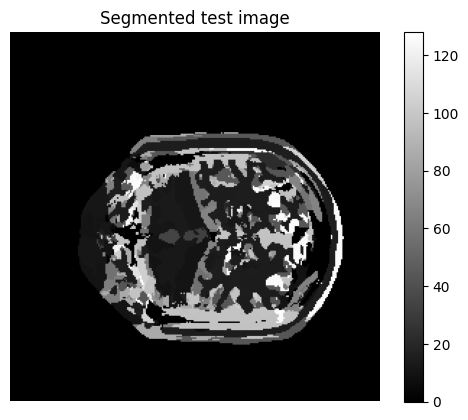

In [15]:
predicted_classes = np.argmax(predictions, axis=1).reshape(test_image.shape)

plt.imshow(predicted_classes, cmap="gray")
plt.colorbar()
plt.axis("off")
plt.title("Segmented test image")

### Problem 2.4

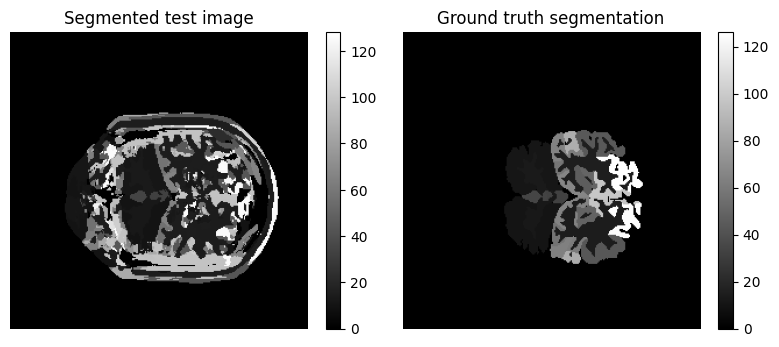

In [16]:
true = imread("1003_3_seg.png")

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(predicted_classes, cmap="gray")
plt.colorbar(shrink=0.8)
plt.axis("off")
plt.title("Segmented test image")

plt.subplot(1, 2, 2)
plt.imshow(true, cmap="gray")
plt.colorbar(shrink=0.8)
plt.axis("off")
plt.title("Ground truth segmentation")

plt.tight_layout()

In [17]:
def evaluate_dice(prediction, truth):

    classes = np.arange(1, 136)  # classes from 1 to 135
    DSC = np.zeros(135)  # initialize array for Dice coefficients

    for i, c in enumerate(classes):  # loop over all classes and compute Dice coefficients
        if(np.sum(prediction==c) == 0) and (np.sum(truth==c) == 0):
            DSC[i] = 1
        else:
            DSC[i] = 2 * np.sum((prediction==c) & (truth==c)) / (np.sum(prediction==c) + np.sum(truth==c))
    
    return np.mean(DSC)  # compute mean over all classes

In [18]:
dice_test = evaluate_dice(predicted_classes, true)
print(f"The Dice coefficient of the segmentation is: {dice_test}")

The Dice coefficient of the segmentation is: 0.6499261157114075
